<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(cw_attack_manual.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Carlini & Wagner Attack - Manual Approach

### Lab Objectives:  
- Learn about the Carlini and Wagner (C&W) attack from the manual perspective  
- Implement the C&W attack  
- Learn about the C&W attack custom loss function   
- Visualize the perturbations 
- Visualize the perturb image  


### Step 1:  

In [1]:
# Import some libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')
print(f'Requests version used:  {requests.__version__}')

Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3
Requests version used:  2.32.4


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# I am going to cheat here. 
# I seem to be running into a problem with my GPU and backpropagation. 
# So to address that, I am forcing this to use CPU.
# You can test on your system by commenting out this line below and running the code
# However, without the GPU this works just fine!
device = 'cpu'

Rather than building our own model, we take a pre-trained model and target it instead. The pre-trained model we target will be the resnet50 model: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html  

In [5]:
# Load a pretrained resnet model and set it to eval mode
print(f'[*] Loading model ...')
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
model.eval() 
print('[*] Model switched to eval mode')

[*] Loading model ...
[*] Model switched to eval mode


When the model was trained, the images consisted of three channels. Each of these channels were also standardize with a mean and standard deviation. Hence, when passing new images into this model, we should make every effort to satisfy this criteria. This standardizing process took each data point, subtracted it from the mean of the channel and divided it by the standard deviation of the channel. i.e. 
    
               x - mean    
    std_x = -------------    
                 std    

Additionally, if the input image is larger or smaller than 256x256 pixels, we will resize it to ensure the size going into the model is 256x256.  We also Want to center crop the image. Basically it is cropping the image at the center and finally, we ensure the image is a converted to a torch tensor.  

### Step 2:   

In [6]:
# Setup a transform to preprocess the input image
# The model has been trained on preprocessed data
# We need to ensure that the data provided at prediction time is preprocessed the same way

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Similarly to how we normalize the input for the model, we want to unnormalize the data. This is especially needed for visualization of the model's output. 

This is what we had for standardization   
               x - mean    
    std_x = -------------    
                 std  


We can now move things around and get back to the unnormalize data.   Our formula for unnormalizing would look like:   
std_x * std = x - mean   
This is then equal to   
std_x * std + mean = x  
or putting it another way   
x_orig = std_x * std + mean   

Obviously the algorithm is going to use some neat little tricks to solve this problem. However, this concept still applies   


### Step 3:   

In [7]:
# Inverse of the normalization
# Why use these values
inverse_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

With that in place, let us get an image to work with. 

### Step 4:  

In [8]:
# Define a URL variable
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Golden_Retriever_Dukedestiny01_drvd.jpg/500px-Golden_Retriever_Dukedestiny01_drvd.jpg'
response = requests.get(url=url)
if response.status_code == 200:
    print(f'[*] Successfully retrieved file. URL is valid')
    print(response.content)
else:
    print(f'[!] Unable to retrieve file. Please verify the URL: {url} is valid: {response.status_code} ')
    print('[*] Please uncomment and run the cell below: ')

    

[*] Successfully retrieved file. URL is valid
b'\xff\xd8\xff\xdb\x00C\x00\x04\x03\x03\x04\x03\x03\x04\x04\x03\x04\x05\x04\x04\x05\x06\n\x07\x06\x06\x06\x06\r\t\n\x08\n\x0f\r\x10\x10\x0f\r\x0f\x0e\x11\x13\x18\x14\x11\x12\x17\x12\x0e\x0f\x15\x1c\x15\x17\x19\x19\x1b\x1b\x1b\x10\x14\x1d\x1f\x1d\x1a\x1f\x18\x1a\x1b\x1a\xff\xdb\x00C\x01\x04\x05\x05\x06\x05\x06\x0c\x07\x07\x0c\x1a\x11\x0f\x11\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\xff\xc0\x00\x11\x08\x01\x8b\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x06\x03\x04\x02\x07\x08\x00\x01\xff\xc4\x00B\x10\x00\x02\x02\x01\x03\x03\x03\x02\x04\x05\x02\x05\x03\x03\x02\x07\x01\x02\x03\x04\x11\x05\x12!\x00\x061\x13"A\x14Q\x072aq\x15#B\x81\x91R\xa1$3b\xb1\xc1\x16\xd1\xf0r\xe1\xf1\x08%C\x82S\x92\xa2&4\xff\xc4\x

If for some reason the above fails, this file is also in the data folder. Here are some steps to take:  
- Open a terminal/shell/command prompt   
- Go to the data folder. eg. cd ..
- My data folder looks like: ../data/Golden_Retriever_Dukedestiny01_drvd.jpg
- Once in this folder load up a python webserver by doing 
- $ python -m http.server 8080
- You should see: Serving HTTP on 0.0.0.0 port 8080 (http://0.0.0.0:8080/) ... 

With this in place you can uncomment below and get the file  

In [9]:
# Define a URL variable
#url = 'http://127.0.0.1:8080/Golden_Retriever_Dukedestiny01_drvd.jpg'

#if response.status_code == 200:
#    print(f'[*] Successfully retrieved file. URL is valid')
#    print(response.content)
#else:
#    print(f'[!] Unable to retrieve file. Please verify the URL: {url} is valid: {response.status_code} ')
#    print('[*] Please uncomment and run the cell below: ')

Alternatively, if you don't have patience for any of above, simply read the file instead. 

In [10]:
# If for some reason the above fai
# Alternative for the image of the dog
# Only uncomment if above fails or return a status code other than 200

#img = Image.open(fp='../data/Golden_Retriever_Dukedestiny01_drvd.jpg')
#plt.imshow(img)
#plt.axis('off')
#img_transformed = transform(img=img).unsqueeze(dim=0)
#img_transformed

Let us also get the labels to work with. 

### Step 5

In [11]:
# Get all the labels. Just a reference point
resnet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
resnet_labels = requests.get(url=resnet_labels_url).json()
print(resnet_labels[:5])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']


If above fails, then grab the content locally by uncomment the lines below.   

You might be wondering why I did not just let you read the file system and get the file. The reality is, we need to know how to work with data that is coming from multiple sources. This is a good example for us to get enough practice.  

In [12]:
# Get the labels via backup method if the original fail
# Uncomment below if you encounter errors with the request
# Only if a response other than 200 is returned
#with open(file='resnet_labels.txt', mode='rt') as fp:
#    resnet_labels = fp.read().replace('"', '').split('\n')

#print(resnet_labels[:5])


In [13]:
# Rather than a list, let's make this into a dictionary
resnet_labels = { key:value for key,value in enumerate(resnet_labels, start=0)}
resnet_labels

{0: 'tench',
 1: 'goldfish',
 2: 'great white shark',
 3: 'tiger shark',
 4: 'hammerhead shark',
 5: 'electric ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house finch',
 13: 'junco',
 14: 'indigo bunting',
 15: 'American robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'American dipper',
 21: 'kite',
 22: 'bald eagle',
 23: 'vulture',
 24: 'great grey owl',
 25: 'fire salamander',
 26: 'smooth newt',
 27: 'newt',
 28: 'spotted salamander',
 29: 'axolotl',
 30: 'American bullfrog',
 31: 'tree frog',
 32: 'tailed frog',
 33: 'loggerhead sea turtle',
 34: 'leatherback sea turtle',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle',
 38: 'banded gecko',
 39: 'green iguana',
 40: 'Carolina anole',
 41: 'desert grassland whiptail lizard',
 42: 'agama',
 43: 'frilled-necked lizard',
 44: 'alligator lizard',
 45: 'Gila monster',
 46: 'European green lizard',
 47: 'chameleon',
 48: 'Komodo dragon',
 49: 'Nile c

Let us now create a function to simplify some of this problem for us going forward, with taking an image and converting it to a tensor.   

### Step 6:  

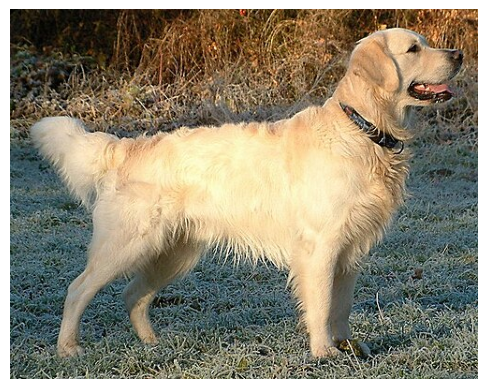

torch.Size([1, 3, 224, 224])

In [14]:
# Get an image from a URL and transform it to a tensor
def get_image_from_url(image_url=None, show_image=False):
    response = requests.get(url=image_url)
    img = Image.open(fp=BytesIO(initial_bytes=response.content)).convert('RGB')
    
    if show_image:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    img_transformed = transform(img)
    # Add a batch dimension to the image. Input to the network needs to be (-1, 3, 224, 224)
    img_transformed = img_transformed.unsqueeze(dim=0)

    # Return the transformed tensor
    return img_transformed.to(device)

# Test the function
# Only look at the output shape
get_image_from_url(image_url=url, show_image=True).shape

In [15]:
# Make a prediction on this sample image
# First get the image
sample_x = get_image_from_url(image_url=url)

# Make a prediction on the tensor
logits = model(sample_x)

# Identify the class of the sample
resnet_labels.get(logits.max(dim=-1)[1].item()), logits.max(dim=-1)[1], logits.max(dim=-1)[0]

('Golden Retriever', tensor([207]), tensor([18.0372], grad_fn=<MaxBackward0>))

Let us now undo this process by reverting from a tensor back to an image.   

### Step 7:  

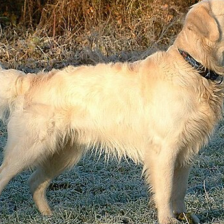

In [16]:
# Now that we know how to get from an image to a tensor, let's revert this process
# let's go from tensor to image
def get_image_from_tensor(tensor=None):

    # First remove the batch dimension
    tensor = tensor.squeeze(dim=0)

    # undo the normalization which was done to prepare for prediction
    tensor = inverse_normalize(tensor)
    
    # Force the imae back to a range between 0 and 1
    # We hope the image is back between 0 and 1 but just in case it is not, let's clamp it
    tensor = tensor.clamp(min=0, max=1)
    #print(f'Shape of tensor is: {tensor.shape}')

    # Get the final image
    img = transforms.ToPILImage(mode='RGB')(tensor)    

    return img

# test the function
get_image_from_tensor(tensor=sample_x)

Let us learn about the C&W attack the hard way, by writing our own code to implement it. This way, we have a solid intuition about exactly what is going on. 

### Step 8: 

In [17]:
# Setup the C&W attack via a class
# This will be targeted attack, as in we would like a particular label as our target
# We will ignore the binary search but still be able to achieve our objective

class CarliniWagnerWAttack(nn.Module):
    def __init__(self, model=None, c=1e-5, n_classes=1000, k=0, lr=0.01, max_iters=1000):
        super(CarliniWagnerWAttack, self).__init__()
        self.model = model
        self.c = c
        self.n_classes = n_classes
        self.k = k
        self.lr = lr
        self.max_iters = max_iters
    
    def _custom_loss_fn(self, Z, tgt_label, real_x, adv_x, c):
        ''' 
        Z: logits -> raw output from the network
        tgt_label: The class we would like real_x to be changed to
        real_x: unormalized real input in the range [0, 1]
        adv_x: unormalized adversarial input in the range [0, 1]
        c: Find the right balance between an effective attack and a small enough perturbation
        '''

        # ========= First part of our loss: max(max(Z_i != t) - Z_t, -k)  =============
        # Let's build a one hot vector for our target label
        tgt_one_hot = torch.zeros_like(input=Z).scatter_(dim=-1, index=torch.tensor([[tgt_label]]), value=1)

        # Get the current logits for our target class. This needs to be higher than everything else
        # Multiplying the one hot vector, with mostly 0s, will result in all but our target class being a non zero value
        Z_t = (tgt_one_hot * Z).sum(dim=-1)

        # Extract the highest logit among all logits, excluding our target label
        # This should be lower than our target
        # Realistically, it should also be the true class of the input
        Z_i_neq_t = ((1 - tgt_one_hot ) * Z - (tgt_one_hot * 100000)).max(dim=-1)[0]

        # If (Z_i_neq_t - Z_t) > 0, then our target class is not the highest. We want this to be negative
        # Now we don't only want this to be negative but we want it to be so by some amount k.
        # k controls the confidence or that "some amount"
        loss_f = torch.clamp(Z_i_neq_t - Z_t + self.k , min=0)

        # A positive loss means and unsuccessful attack
        # We are looking for 0 or a value close to 

        # =========== and the second part ===============
        # We L2 norm (Euclidean distance) to find how much our adversarial output, differs from the original input
        # At the same time, we flatten the perturbation for simplicity to view all channels and pixels
        perturbation = (adv_x - real_x).view(adv_x.size(dim=0), -1)
        l2_norm = torch.norm(input=perturbation, p=2, dim=-1)

        # ======= FINISH UP THE LOSS BY COMBINING PARTS 1 AND 2 ABOVE ===========
        # Note, we can optimize for the perturbation such as:
        # total_loss = loss_f + self.c * l2_norm

        # Or as in the original paper, optimize for the classification
        total_loss = l2_norm + self.c * loss_f

        return total_loss, loss_f, l2_norm
    

    def forward(self, real_x, tgt_label):
        # How many Xs are we working with one or more
        n_images = real_x.size(dim=0)

        # Get the pixels in range [0, 1]
        real_x_unnormalized = inverse_normalize(real_x.squeeze(dim=0)).unsqueeze(dim=0)

        # This pushes the values now to be -1 and 1 as we prepare for atanh
        real_x_pre_tanh = (real_x_unnormalized * 2) -1

        # When running torch.atanh, any values greater than -1 or +1 will be flagged as nan
        # At the same time, any value equaling -1 or +1 will be flagged as -inf and inf respectively
        # To avoid those nans and infs we will clip our values to a min of -0.999999 and max +0.999999
        w = torch.atanh(input=torch.clamp(input=real_x_pre_tanh, min=-0.999999, max=0.999999))

        # We wish to find the right value for w. Hence we are optimizing for w
        w = nn.Parameter(data=w.clone().detach(), requires_grad=True)

        # Since we are optimizing for w, we then need an optimizer
        optimizer = torch.optim.Adam(params=[w], lr=self.lr)

        # c balances our perturbation with the classification.
        c = torch.tensor([self.c] * n_images)

        # Track our progress via the best adversarial example and the associated L2 norm
        best_adv_x = real_x.clone()
        best_l2_norm = float('inf')

        print(f'[*] Performing C&W Targeted attack for target: {resnet_labels.get(tgt_label, "Target Not found!")} ')

        for iter in range(self.max_iters):
            # Clear any previous gradients
            optimizer.zero_grad(set_to_none=True)

            # Bring w back into the range[0,1]
            adv_x_unnormalized = (torch.tanh(input=w) + 1.) / 2.

            # Apply the imagenet normalization on the unnormalized data
            adv_x_normalized = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(adv_x_unnormalized)

            # Get the logits for the adversarial example
            Z = self.model(adv_x_normalized)

            # Call the loss using the custom loss function
            total_loss, loss_f, l2_norm = self._custom_loss_fn(Z=Z, tgt_label=tgt_label, real_x=real_x, adv_x= adv_x_unnormalized, c=c)

            # If the batch consists of more than 1 samples, we will need to reduce the values
            # We do so via sum and start backpropagation
            total_loss.sum().backward()

            # update w
            optimizer.step()

            # Is our attack successful, let's find out
            predicted_tgt = Z.argmax(dim=-1).item()
            is_successful = (predicted_tgt == tgt_label)

            if (iter + 1) %  2 == 0 or is_successful:
                print(f'[*] {iter+1}/{self.max_iters}'
                        f'[*] Total loss: {total_loss.item():.4f} \t Loss_f: {loss_f.item():.4f} \t L2 Norm: {l2_norm.item():.4f}'
                        f'\t Predicted label: {predicted_tgt} => Target label:{tgt_label}')
            
            # Let's track the l2 norm to find th ebest one
            if is_successful and (l2_norm.item() < best_l2_norm):
                best_l2_norm = l2_norm.item()

                # Store the best adversarial example
                best_adv_x = adv_x_normalized.detach().clone()

                print(f'[*] ATTACK IS SUCCESSFUL @ iteration: {iter+1}. Best L2 norm={best_l2_norm:.4f}: Value of c was: {self.c}')

                # Once we are successful stop the attack
                break

            
            # This break is for testing, to stop after the first iter
            #break
            
        # Return the results
        return best_adv_x, best_l2_norm, is_successful

Does above work? Time to test it out   

### Step 9: 

In [18]:
# Test the custom loss function
# This returns total_loss, loss_f, l2_norm
torch.manual_seed(10)
cw_attack = CarliniWagnerWAttack(model=model, k=0, c=5, max_iters=10)
cw_attack._custom_loss_fn(model(sample_x), tgt_label=2, real_x=sample_x, adv_x=sample_x, c=10)

(tensor([97.1990], grad_fn=<AddBackward0>),
 tensor([19.4398], grad_fn=<ClampBackward1>),
 tensor([0.]))

In [19]:
# Test the attack
cw_attack(real_x=sample_x, tgt_label=2)

[*] Performing C&W Targeted attack for target: great white shark 
[*] 2/10[*] Total loss: 372.0784 	 Loss_f: 7.3127 	 L2 Norm: 335.5147	 Predicted label: 194 => Target label:2
[*] 4/10[*] Total loss: 335.5175 	 Loss_f: 0.0000 	 L2 Norm: 335.5175	 Predicted label: 2 => Target label:2
[*] ATTACK IS SUCCESSFUL @ iteration: 4. Best L2 norm=335.5175: Value of c was: 5


(tensor([[[[-1.7037e+00, -1.6497e+00, -1.7209e+00,  ...,  1.9248e+00,
             1.8331e+00,  1.7462e+00],
           [-1.6464e+00, -1.5930e+00, -1.6450e+00,  ...,  2.0060e+00,
             1.9026e+00,  1.8874e+00],
           [-1.6487e+00, -1.8549e+00, -1.7826e+00,  ...,  2.0696e+00,
             1.9885e+00,  1.9875e+00],
           ...,
           [-3.2525e-01, -9.1736e-01, -1.3656e+00,  ...,  3.7832e-01,
             3.3355e-01,  3.6817e-01],
           [-1.9005e-01,  1.4807e-03, -3.2415e-01,  ...,  8.1375e-02,
             9.0658e-02,  9.7158e-02],
           [-1.5034e-01, -1.9985e-01, -8.1727e-01,  ...,  6.4356e-01,
             4.9463e-01,  1.8008e-01]],
 
          [[-1.7426e+00, -1.6707e+00, -1.7420e+00,  ...,  1.6286e+00,
             1.4920e+00,  1.4078e+00],
           [-1.6722e+00, -1.6169e+00, -1.6708e+00,  ...,  1.6432e+00,
             1.4785e+00,  1.4389e+00],
           [-1.7217e+00, -1.9171e+00, -1.8508e+00,  ...,  1.5931e+00,
             1.5925e+00,  1.6428e+00],


Above suggest we are good to go and are heading in the right direction. Let us run the real image through to see what results we get.   

Because we have a tensor, we need to get this back to an image, so we call our *get_image_from_url* function, to help us out.   

### Step 10:  

In [20]:
# Get the tensor of the image
real_x = get_image_from_url(image_url=url, show_image=False)
real_x.shape

torch.Size([1, 3, 224, 224])

In [21]:
# Get the prediction on the original image
# Disable gradient tracking with the 
with torch.no_grad():

    # Get the logits
    Z = model(real_x)

    # Get the probabilities from the logits via softmax
    probs = torch.softmax(input=Z, dim=-1)

    real_y = probs.argmax(dim=-1).item()
    real_z_confidence = probs[0, real_y].item()

print(f'[*] True Prediction: {resnet_labels.get(real_y)} at index: {real_y} with confidence: {real_z_confidence * 100:.2f}%')

[*] True Prediction: Golden Retriever at index: 207 with confidence: 73.75%


Visualize our results. The item in red, represents the index with the highest value. This is the index/class the model predicted for this sample.  

### Step 11:  

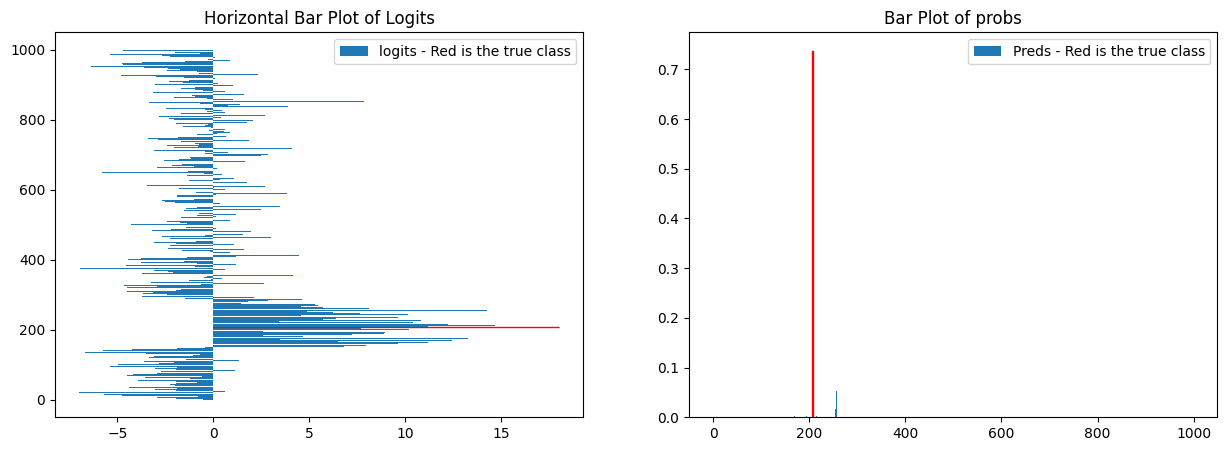

In [22]:
# plot the logits just for our own need
# You can comment out this portion if you do not wish to see the plots
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Horizontal Bar Plot of Logits')
hbars = plt.barh(range(len(Z[0].tolist())), Z[0].tolist())
hbars[torch.max(Z, dim=-1)[1].item()].set_color('red')
plt.legend(['logits - Red is the true class'])

# plot the logits just for our own need
# You can comment out this portion if you do not wish to see the plots
plt.subplot(122)
plt.title('Bar Plot of probs')
bars = plt.bar(range(len(probs[0].tolist())), probs[0].tolist())
bars[torch.max(Z, dim=-1)[1].item()].set_color('red')
plt.legend(['Preds - Red is the true class'])
plt.show()

We know the attack works so far based on our testing. Let's now prepare to finalize this. What target label do we want to flag this as? 

Remember, we can look at the resent labels via

In [23]:
# to get th elabels we can print
print(resnet_labels)

# For simplicity, let's try to make this a Great White Shark which is at index 2
# you can play around with other labels
tgt_label = 2
resnet_labels.get(tgt_label, 'Unknown Label Specified')

{0: 'tench', 1: 'goldfish', 2: 'great white shark', 3: 'tiger shark', 4: 'hammerhead shark', 5: 'electric ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house finch', 13: 'junco', 14: 'indigo bunting', 15: 'American robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'American dipper', 21: 'kite', 22: 'bald eagle', 23: 'vulture', 24: 'great grey owl', 25: 'fire salamander', 26: 'smooth newt', 27: 'newt', 28: 'spotted salamander', 29: 'axolotl', 30: 'American bullfrog', 31: 'tree frog', 32: 'tailed frog', 33: 'loggerhead sea turtle', 34: 'leatherback sea turtle', 35: 'mud turtle', 36: 'terrapin', 37: 'box turtle', 38: 'banded gecko', 39: 'green iguana', 40: 'Carolina anole', 41: 'desert grassland whiptail lizard', 42: 'agama', 43: 'frilled-necked lizard', 44: 'alligator lizard', 45: 'Gila monster', 46: 'European green lizard', 47: 'chameleon', 48: 'Komodo dragon', 49: 'Nile crocodile', 50: 'American alligator', 51: 'tricera

'great white shark'

As mentioned before, above was a lot of testing, we are preparing to wrap this up.  When we call the attack, we wll capture the various values returned such as the adversarial example, the l2 norm, also whether the attack was successful or not. 

### Step 12:  

In [24]:
# Setup the final attack 
cw_attack = CarliniWagnerWAttack(model=model, c=5, n_classes=len(resnet_labels), k=0, lr=0.01, max_iters=1000)

# Get the results returned from call the forward method
adv_x, l2_norm, attack_success = cw_attack(real_x, tgt_label)

[*] Performing C&W Targeted attack for target: great white shark 
[*] 2/1000[*] Total loss: 372.0784 	 Loss_f: 7.3127 	 L2 Norm: 335.5147	 Predicted label: 194 => Target label:2
[*] 4/1000[*] Total loss: 335.5175 	 Loss_f: 0.0000 	 L2 Norm: 335.5175	 Predicted label: 2 => Target label:2
[*] ATTACK IS SUCCESSFUL @ iteration: 4. Best L2 norm=335.5175: Value of c was: 5


We see above our final attack is successful after 5 iterations. Not bad. 

Let us run the model on the adversarial example, to confirm we were able to change the class via our perturbations. 

[*] Getting information from adversarial example
[*] Adversarial Prediction: great white shark at index: 2 with confidence: 61.25%
[*] Perturbation between (real_x and adversarial_x) is: 335.5175
[*] Perturbation Max: 0.015021353960037231 	 Min: -0.015016883611679077
[*] Perturbation scaled Max: 1.0 	 Min: 0.0


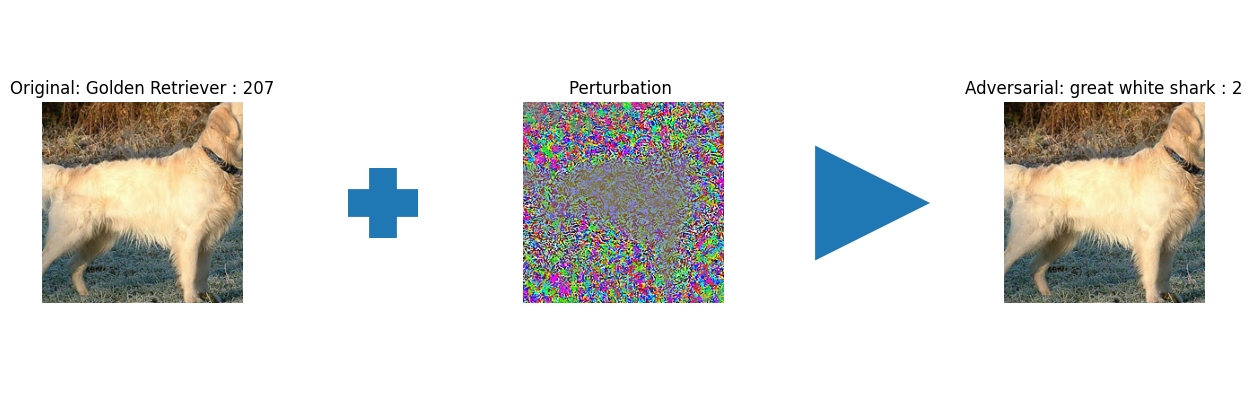

In [25]:
# Promise, this is where we finish up
# if the attack is successful, let's visualize
if attack_success:
    print(f'[*] Getting information from adversarial example')

    # Disable gradient tracking
    with torch.no_grad():

        # Get the logits for the adversarial example
        adv_Z = model(adv_x)

        # How confident is the prediction? Let's get the probabilities
        adv_probs = torch.softmax(input=adv_Z, dim=-1)

        # Get the predicted label for the adversarial example
        adv_pred_label = adv_Z.argmax(dim=-1).item()

        # How confident is the prediction
        adv_confidence = adv_probs[0, adv_pred_label].item()

    print(f'[*] Adversarial Prediction: {resnet_labels.get(adv_pred_label)} at index: {adv_pred_label} with confidence: {adv_confidence * 100:.2f}%')
    print(f'[*] Perturbation between (real_x and adversarial_x) is: {l2_norm:.4f}')

    # Always good to visualize our results. Seeing is believing :-D 
    real_x_img = get_image_from_tensor(tensor=real_x)
    adv_x_img = get_image_from_tensor(tensor=adv_x)

    # Perturbation is being done on the unnormalized data
    real_x_unnormalized = inverse_normalize(real_x.squeeze(dim=0))
    adv_x_unnormalized = inverse_normalize(adv_x.squeeze(dim=0))

    # Get the perturbation
    perturbation = adv_x_unnormalized - real_x_unnormalized
    print(f'[*] Perturbation Max: {perturbation.max()} \t Min: {perturbation.min()}')
    # Scale the perturbation back between 0 and 1 using min max scaling
    # This is for visualization
    perturbation_scaled = (perturbation - perturbation.min()) / ( perturbation.max() - perturbation.min() )
    print(f'[*] Perturbation scaled Max: {perturbation_scaled.max()} \t Min: {perturbation_scaled.min()}')

    # Get the perturbation as an image
    perturbation_img = transforms.ToPILImage()(pic=perturbation_scaled)

    # With everything in place, let's visualize 
    plt.figure(figsize=(15, 5))
    plt.subplot(1,5,1)
    plt.title(label=f'Original: {resnet_labels.get(real_y, "Unknown Label Specified")} : {real_y}')
    plt.imshow(X=real_x_img)
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.plot([5], marker='+', markersize=50, mew=20)
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title(label=f'Perturbation ')
    plt.imshow(X=perturbation_img)
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.plot([5], marker='>', markersize=50, mew=20)
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title(label=f'Adversarial: {resnet_labels.get(tgt_label, "Unknown Label Specified")} : {tgt_label}')
    plt.imshow(X=adv_x_img)
    plt.axis('off')

    plt.show()
    
else:
    print(f'[!] Oops! Attack failed! Try adjusting the hyperparameters, c, k, lr, max_iters. c is a very important hyperparameter.')

In [26]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cpu cache


Awesome, we were able t perform the Carlini and Wagner attack from the manual perspective.

### Lab Takeaways:  
- With this understanding, we are now good to go   
- We are in a position where we saw a small amount of perturbation can result in the model changing the class of an inpu  
- With the foundation set, we are now ready to move on with using a tool to solve this problem.  